In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import tqdm

In [2]:
import gp_aug
import regressor
import utils

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
plt.rcParams['font.size'] = 15

In [5]:
metadata = pd.read_csv('../data/plasticc/plasticc_train_metadata.csv.gz')
data = pd.read_csv('../data/plasticc/plasticc_train_lightcurves.csv.gz')

data = data[data.detected_bool == 1]

In [6]:
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
data.head()

,object_id,mjd,passband,flux,flux_err,detected_bool
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [8]:
object_ids = np.unique(data.object_id)

In [32]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}
passband2color = {
    0: 'blue', 2: 'green', 4: 'magenta',
    1: 'orange', 3: 'red', 5: 'brown'
}

In [20]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

def compile_obj(t, flux, flux_err, passband):
    obj = pd.DataFrame()
    obj['mjd']      = t
    obj['flux']     = flux
    obj['flux_err'] = flux_err
    obj['passband'] = passband
    return obj

def is_good(anobject, peak_mjd):
    if peak_mjd < anobject['mjd'].min() or peak_mjd > anobject['mjd'].max():
        return False
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        return False
    
    # keep only objects with at least 5 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 5:
            count += 1
    if count > 3:
        return False
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        return False
    
    return True

def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best',fontsize=14)
    plt.title(title, size=14)

In [26]:
def GP_estimate_curve_peak(anobject, n_obs=1000):
    model = gp_aug.GaussianProcessesAugmentation(passband2lam)
    model.fit(anobject['mjd'].values, anobject['flux'].values, 
              anobject['flux_err'].values, anobject['passband'].values)
    t_aug, flux_aug, flux_err_aug, passband_aug = model.augmentation(anobject['mjd'].min(), 
                                                                     anobject['mjd'].max(), n_obs=n_obs)
    anobject_aug = compile_obj(t_aug, flux_aug, flux_err_aug, passband_aug)
    curve = anobject_aug[['mjd', 'flux']].groupby('mjd', as_index=False).sum()
    return curve['mjd'][curve['flux'].argmax()]


def residuals_histogram(all_objects):
    plt.figure(figsize=(10, 7))
    plt.hist(all_objects['true_peakmjd'].values - all_objects['pred_peakmjd'].values, bins=50)
    plt.xlabel('mjd residuals', fontsize=15)
    plt.show()
    
    
def plot_light_curves_with_peak(anobject, true_peak_mjd=None, title="", n_obs=1000):
    model = gp_aug.GaussianProcessesAugmentation(passband2lam)
    model.fit(anobject['mjd'].values, anobject['flux'].values, 
              anobject['flux_err'].values, anobject['passband'].values)
    t_aug, flux_aug, flux_err_aug, passband_aug = model.augmentation(
        anobject['mjd'].min(), 
        anobject['mjd'].max(),
        n_obs=n_obs
    )
    anobject_aug = compile_obj(t_aug, flux_aug, flux_err_aug, passband_aug)
    curve = anobject_aug[['mjd', 'flux']].groupby('mjd', as_index=False).sum()
    pred_peak_mjd = curve['mjd'][curve['flux'].argmax()]

    plt.figure(figsize=(12, 7))
    for passband in range(6):
        light_curve = get_passband(anobject_aug, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=1,
                 color=passband2color[passband])
        light_curve = get_passband(anobject, passband)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, 
                    label=passband2name[passband], color=passband2color[passband], linewidth=1)
    plt.plot(curve['mjd'].values, curve['flux'].values, label='Sum', linewidth=1, color='pink')

    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)

    plt.axvline(pred_peak_mjd, label='Pred peak', color='gray')
    if true_peak_mjd is not None:
        plt.axvline(true_peak_mjd, label='True peak', color='black')
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)
        
    plt.show()

In [14]:
all_objects = metadata[['object_id', 'true_peakmjd']][metadata.true_target.isin([42, 62])]
mask = all_objects.apply(lambda row: is_good(get_object(data, row['object_id']), row['true_peakmjd']), axis=1)
all_objects = all_objects[mask]
all_objects.shape, metadata.shape

((206, 2), (7848, 26))

In [15]:
%%time

all_objects['pred_peakmjd'] = all_objects['object_id']\
    .apply(lambda x: GP_estimate_curve_peak(get_object(data, x)))

CPU times: user 5min 37s, sys: 5min 35s, total: 11min 12s
Wall time: 1min 37s


In [16]:
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(all_objects['true_peakmjd'].values, 
                                                                      all_objects['pred_peakmjd'].values)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

RMSE:  7.275087063352297
MAE:  4.8638841914728195
RSE:  0.02324134176594021
RAE:  0.017714758235571892
MAPE:  0.008098401795379457


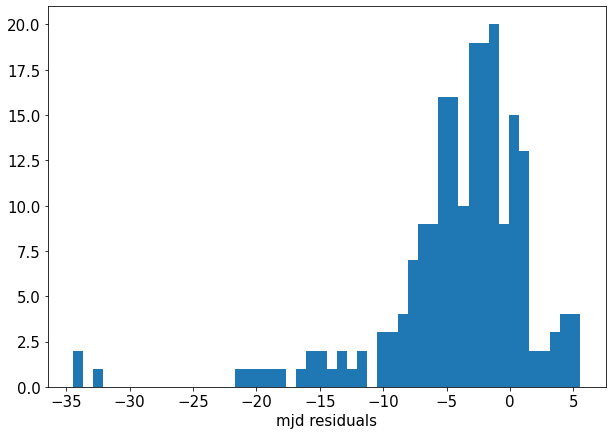

In [22]:
residuals_histogram(all_objects)

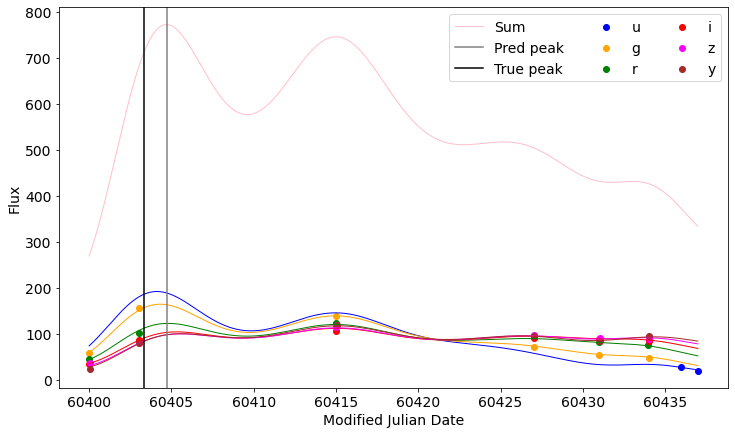

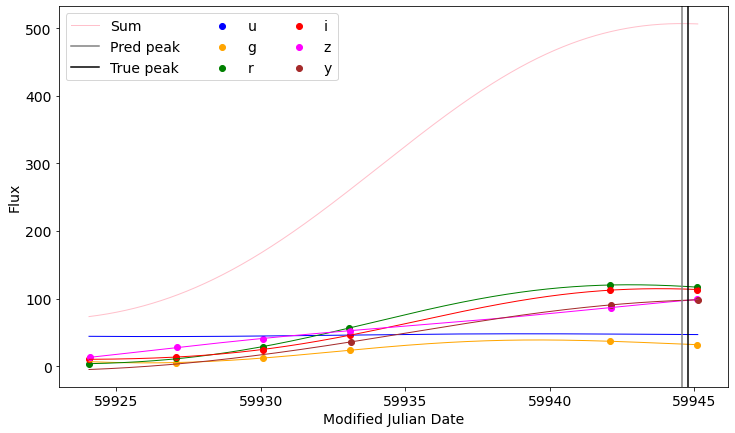

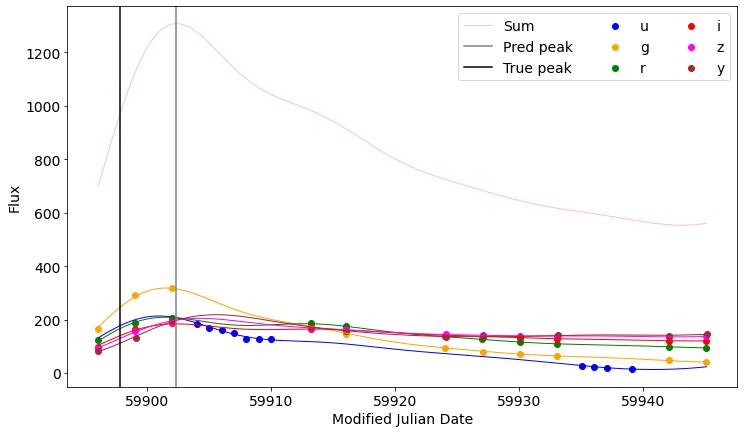

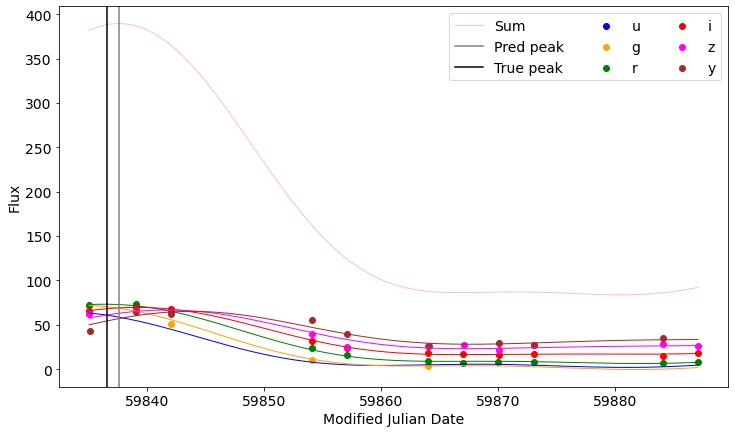

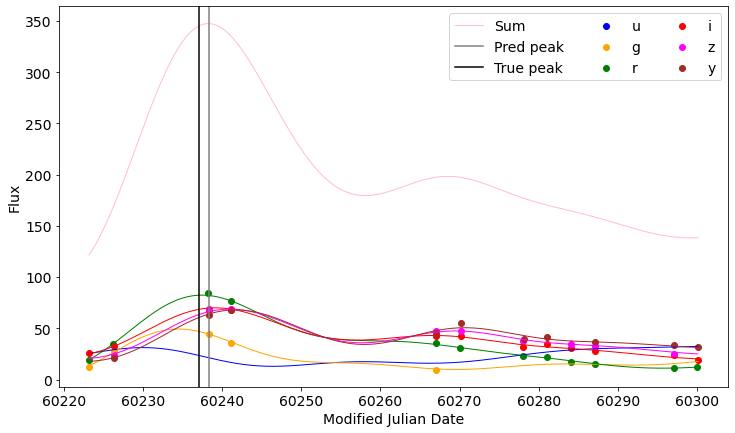

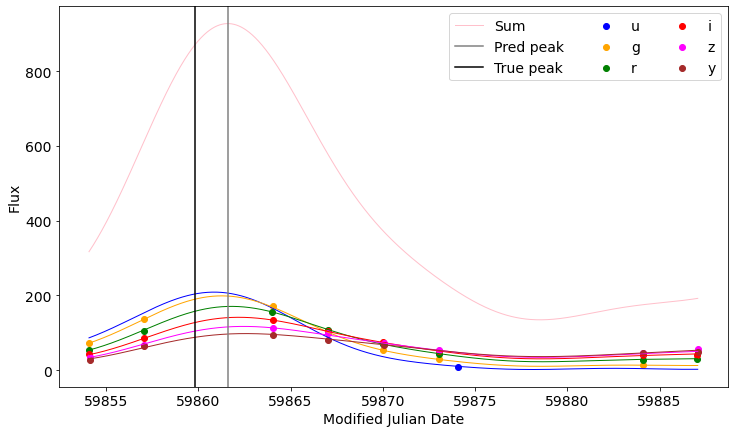

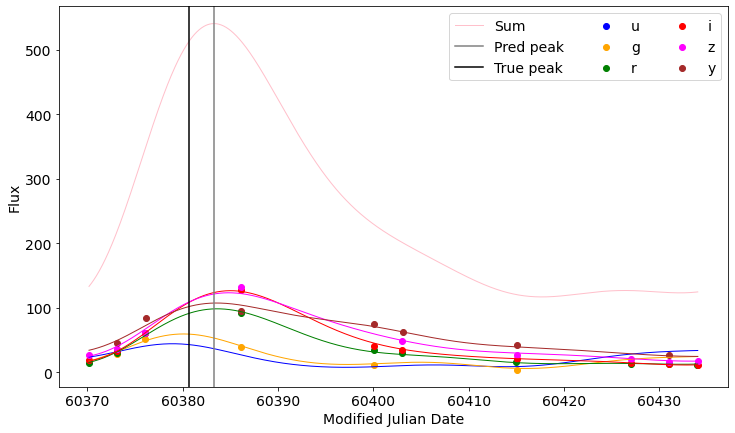

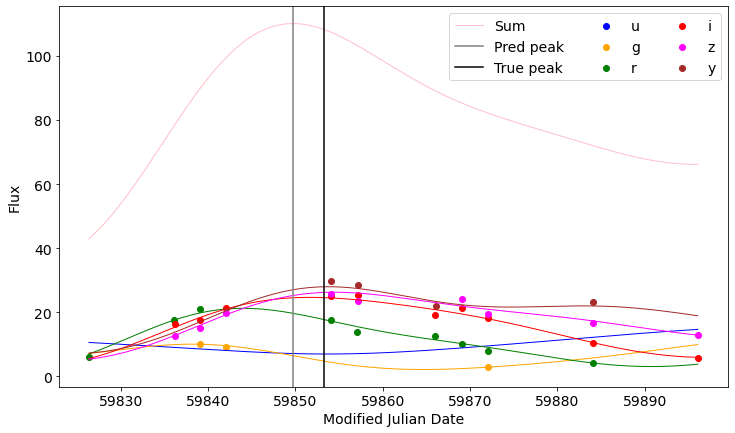

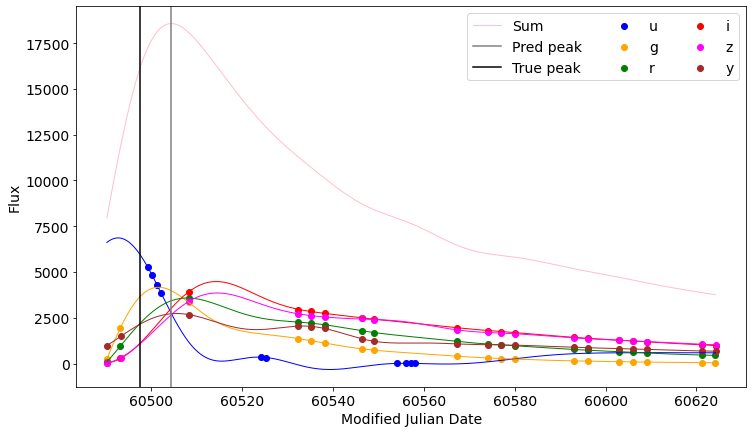

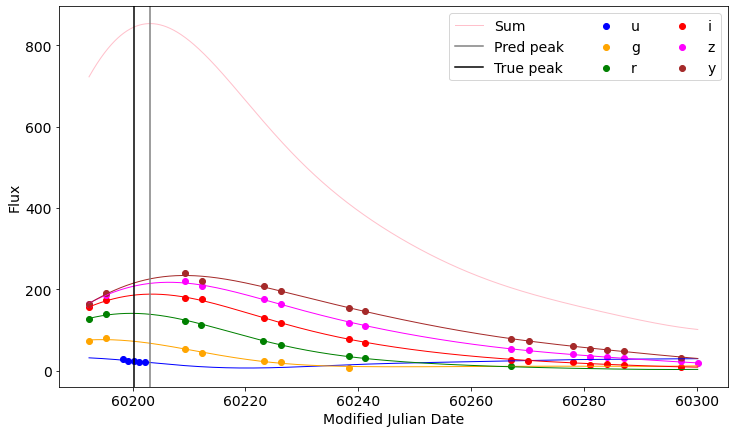

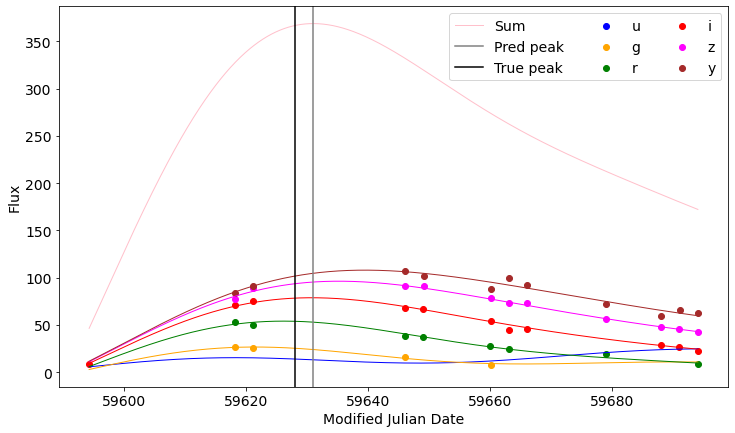

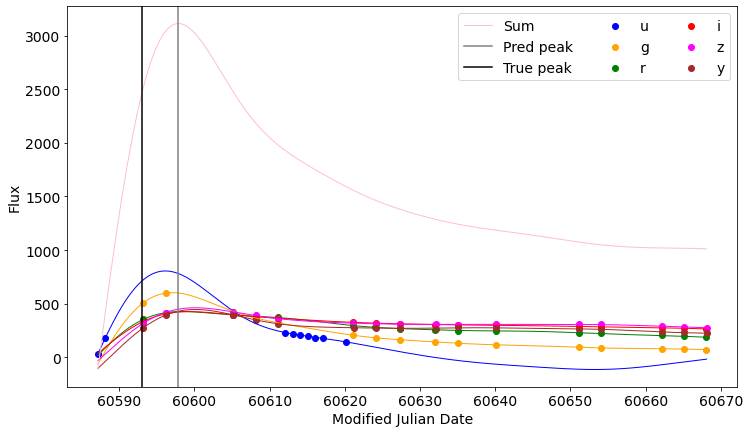

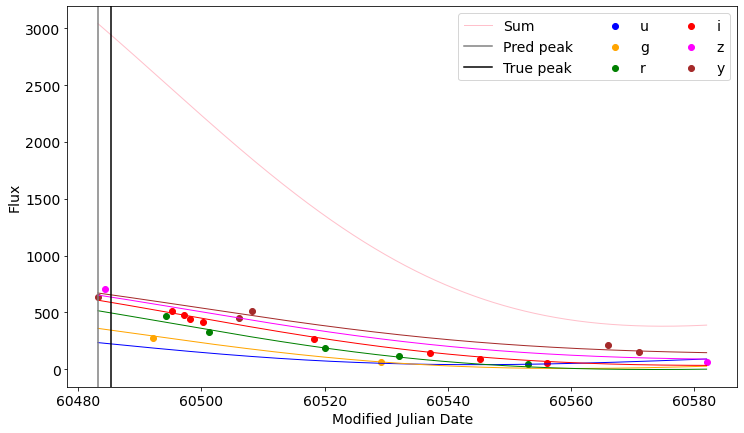

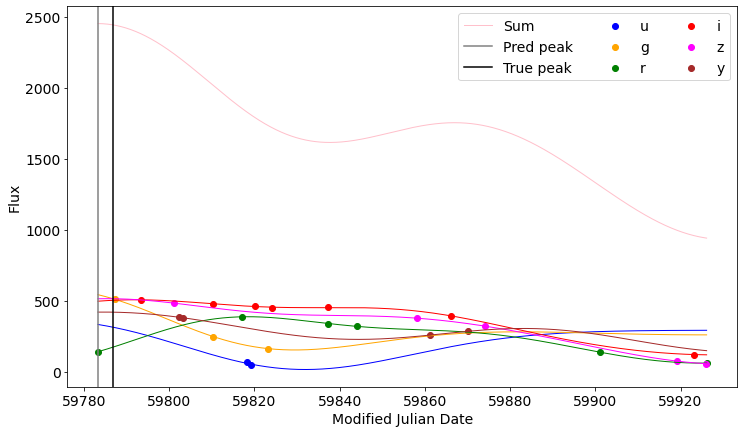

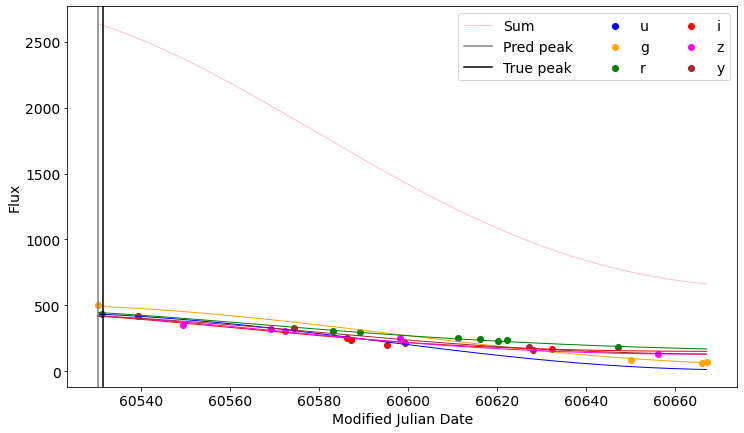

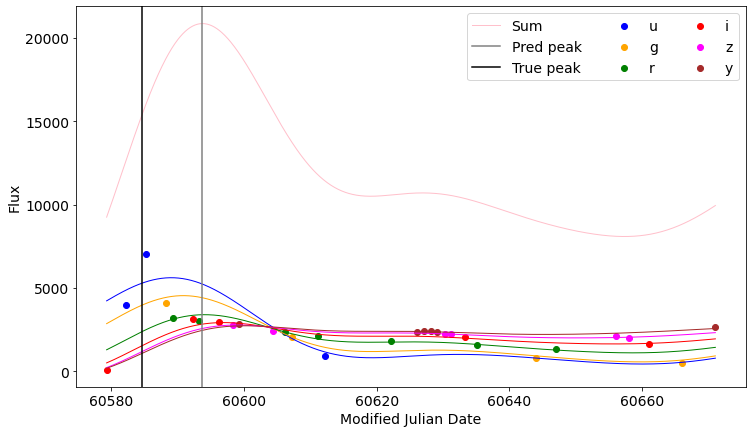

In [33]:
for object_id in all_objects['object_id'].values[::13]:
    plot_light_curves_with_peak(get_object(data, object_id),
                                all_objects[all_objects['object_id']==object_id]['true_peakmjd'].iloc[0])

# Test data

In [41]:
test_metadata = pd.read_csv('../data/plasticc/plasticc_test_metadata.csv.gz',
                            usecols=['object_id', 'true_target', 'true_peakmjd'])
test_metadata = test_metadata[test_metadata['true_target'].isin([42, 62])].drop('true_target', axis=1)
test_metadata.shape

(1175244, 2)

In [42]:
objects_set = set(test_metadata.object_id.values)
len(objects_set)

1175244

In [43]:
def read_test_csv(filename, objects_set):
    test_idx = pd.read_csv(filename, usecols=['object_id']).object_id
    skiprows = test_idx.apply(lambda obj: obj not in objects_set).astype(bool)
    test_detected = pd.read_csv(filename, usecols=['detected_bool']).detected_bool
    skiprows |= ~test_detected.astype(bool)
    skiprows = skiprows.index[skiprows] + 1  # first row contains column names
    df = pd.read_csv(filename, skiprows=skiprows)
    return df

In [46]:
tobe_df = []

for number in range(1, 12):
    data = read_test_csv(f'../data/plasticc/plasticc_test_lightcurves_{number:02}.csv.gz', objects_set)
    for object_id in tqdm.notebook.tqdm(data.object_id.unique()):
        anobject = get_object(data, object_id)
        true_peak = test_metadata[test_metadata.object_id == object_id]['true_peakmjd'].values[0]
        if not is_good(anobject, true_peak):
            continue
        peak = GP_estimate_curve_peak(anobject)
        tobe_df.append({
            'object_id': object_id, 'pred_peakmjd': peak
        })

In [47]:
result_df = pd.merge(pd.DataFrame(tobe_df), test_metadata, on='object_id')

In [50]:
result_df.shape

(10872, 3)

In [48]:
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(result_df['true_peakmjd'].values, 
                                                                      result_df['pred_peakmjd'].values)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

RMSE:  12.00049862525089
MAE:  7.636027880916335
RSE:  0.043272544645829
RAE:  0.030985251725641698
MAPE:  0.012685624906508984


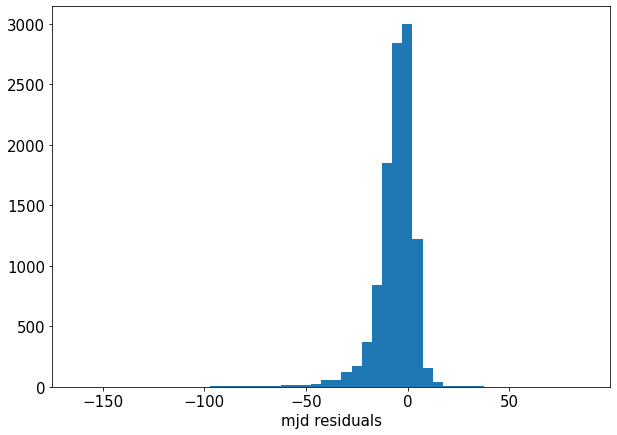

In [49]:
residuals_histogram(result_df)